In [1]:
import utils

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.models import vgg16, resnet50
from typing import Tuple, List, Dict, Any

seed = 42
AMOUNT_OF_FRAMES = 40

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.0/138.0 kB 2.8 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 kB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.2/62.2 MB 7.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.0/9.0 MB 10.4 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 401.2/401.2 kB 5.4 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 785.2/785.2 kB 2.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 8.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 9.3 MB/s eta 0:00:00:00:0100:01


In [2]:
path2data = "/project_ghent/Master-Thesis/gif/blendshape"

SKIP_FRAMES = 1

ids, labels, groups, catgs = utils.get_vids(path2data)
utils.split_dataset(ids, labels, groups, skipframes=SKIP_FRAMES)

Name		 ids labels groups
--------------------------------------
Train: 		 91 91 91
Validation: 	 23 23 23
--------------------------------------
Name distribution:	 YES - NO
Original distribution:	 0.3333333333333333 - 0.6666666666666666
Train distribution:	 0.32967032967032966 - 0.6703296703296703
Val distribution:	 0.34782608695652173 - 0.6521739130434783
--------------------------------------
Succesfully saved at /project_ghent/Master-Thesis/gif/pickled/ with skipframes = 1 []


In [2]:
SKIP_FRAMES = 1
train_ds, val_ds = utils.get_dataset(skipframes=SKIP_FRAMES)

Succesfully retrieved at /project_ghent/Master-Thesis/gif/pickled/ with skipframes = 1 []


In [4]:
train_ds[0][0].shape

torch.Size([40, 52])

1
Training...


Epoch 100/100: 100%|██████████| 6/6 [00:00<00:00,  9.33batch/s, Loss=0.316]


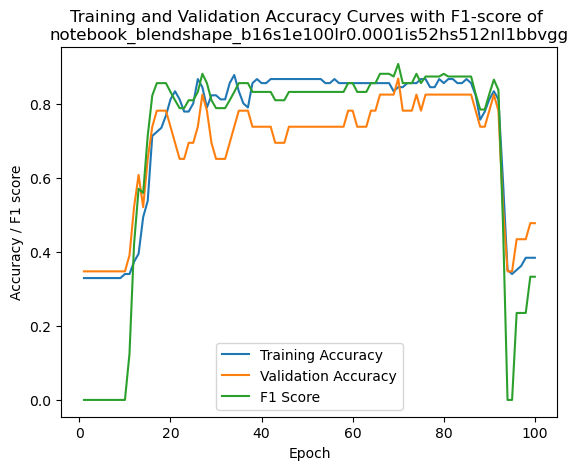

Plotting confusion matrix...


<Figure size 640x480 with 0 Axes>

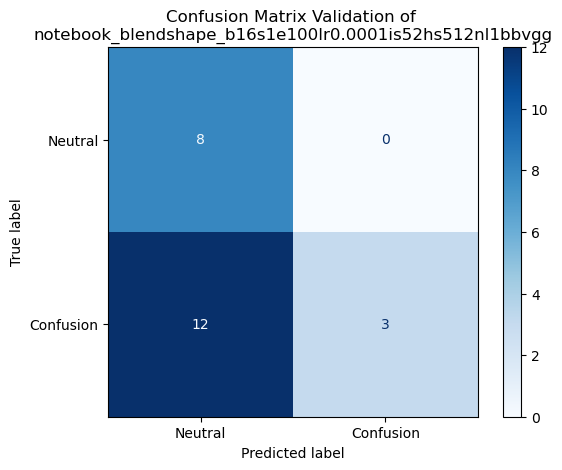

Plotting ROC curve...


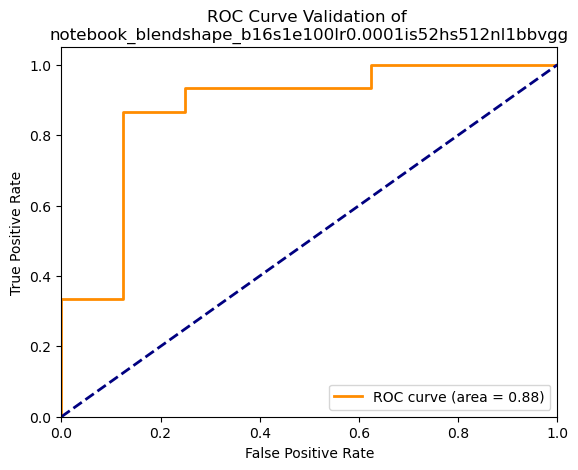

Saving model...


In [4]:
batch_size = 16
skipframes = 1
num_epochs = 100
lr = 1e-4
num_workers = 4
pos_weight = 0.378
INPUT_SIZE = 52
HIDDEN_SIZE = 512
NUM_LAYERS = 1
backbone = "vgg"
num_gpu = 1

name = f"notebook_blendshape_b{batch_size}s{skipframes}e{num_epochs}lr{lr}is{INPUT_SIZE}hs{HIDDEN_SIZE}nl{NUM_LAYERS}bb{backbone}"

train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True, worker_init_fn=np.random.seed(seed), num_workers=num_workers)
val_dl = DataLoader(val_ds, batch_size=2*batch_size, shuffle=False, num_workers=num_workers)  

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = utils.GIFBlendshapeModel(input_size=INPUT_SIZE, hidden_size=HIDDEN_SIZE, num_layers=NUM_LAYERS).to(device)

print(torch.cuda.device_count())
if torch.cuda.device_count() > 1:
    model = nn.DataParallel(model)
model = model.to(device)

# criterion = nn.BCEWithLogitsLoss()
criterion = nn.BCEWithLogitsLoss(reduction='mean', pos_weight=torch.tensor([pos_weight]).to(device))
optimizer = optim.Adam(model.parameters(), lr=lr)

parameters = {"device": device, 
              "epochs": num_epochs,
              "trainloader": train_dl,
              "valloader": val_dl,
              # "testloader": test_dl,
              "criterion": criterion,
              "optimizer": optimizer,
              "batch_size": batch_size,
              "amount_of_frames": AMOUNT_OF_FRAMES // skipframes,
              "categories":  utils.categories.keys(),
              "decision": 0.5}

print("Training...")

utils.train_and_plot(model, parameters, name)

print("Plotting confusion matrix...")

utils.plot_confusionmatrix(model, parameters, name, mode="Validation", verbose=False)

print("Plotting ROC curve...")

utils.plot_roc_curve(model, parameters, name, mode="Validation", verbose=False)

print("Saving model...")

torch.save(model, f"/project_ghent/Master-Thesis/gif/models/image_{name}.pth")